## Loading Data

In [2]:
import pandas as pd
import pandas_datareader.data as web
import datetime

# Define the time period
start = datetime.datetime(2004, 1, 1)
end = datetime.datetime(2024, 1, 1)

# Fetch and resample data
def fetch_and_resample_data():
    # S&P Case-Shiller Home Price Index (Monthly)
    sp_case_shiller = web.DataReader('CSUSHPISA', 'fred', start, end).resample('M').ffill()

    # Mortgage Rate (Weekly to Monthly)
    mortgage_rate = web.DataReader('MORTGAGE30US', 'fred', start, end).resample('M').mean()

    # Unemployment Rate (Monthly)
    unemployment_rate = web.DataReader('UNRATE', 'fred', start, end).resample('M').ffill()

    # Median Income (Annual to Monthly)
    median_income = web.DataReader('MEHOINUSA672N', 'fred', start, end).resample('M').ffill()

    # Housing Starts (Monthly)
    housing_starts = web.DataReader('HOUST', 'fred', start, end).resample('M').ffill()

    # GDP Growth (Quarterly to Monthly)
    gdp_growth = web.DataReader('A191RL1Q225SBEA', 'fred', start, end).resample('M').ffill()

    # Inflation Rate (Monthly)
    inflation_rate = web.DataReader('CPIAUCSL', 'fred', start, end).resample('M').ffill()

    # Population Growth (Monthly)
    population_growth = web.DataReader('POPTHM', 'fred', start, end).resample('M').ffill()

    # S&P 500 Index (Daily to Monthly)
    sp500_index = web.DataReader('SP500', 'fred', start, end).resample('M').mean()

    # Merge all dataframes on the date index
    data = sp_case_shiller.join([mortgage_rate, unemployment_rate, median_income, housing_starts,
                                 gdp_growth, inflation_rate, population_growth, sp500_index])

    # Rename columns for clarity
    data.columns = ['Home_Price_Index', 'Mortgage_Rate', 'Unemployment_Rate', 'Median_Income',
                    'Housing_Starts', 'GDP_Growth', 'Inflation_Rate', 'Population_Growth', 'SP500_Index']

    # Drop rows with any remaining missing values
    data.dropna(inplace=True)

    return data

# Fetch and inspect the data
data = fetch_and_resample_data()

# Check the final dataset
print("\nShape of the final merged dataset:")
print(data.shape)
print("\nFirst few rows of the final merged dataset:")
print(data.head())

if data.empty:
    raise ValueError("The merged dataset is empty. Check the date ranges and availability of the data.")



Shape of the final merged dataset:
(91, 9)

First few rows of the final merged dataset:
            Home_Price_Index  Mortgage_Rate  Unemployment_Rate  Median_Income  \
DATE                                                                            
2014-07-31           164.585         4.1300                6.2        64900.0   
2014-08-31           165.211         4.1150                6.1        64900.0   
2014-09-30           165.901         4.1625                5.9        64900.0   
2014-10-31           166.637         4.0360                5.7        64900.0   
2014-11-30           167.331         3.9975                5.8        64900.0   

            Housing_Starts  GDP_Growth  Inflation_Rate  Population_Growth  \
DATE                                                                        
2014-07-31          1085.0         5.0         237.498           319670.0   
2014-08-31           984.0         5.0         237.460           319919.0   
2014-09-30          1023.0         

##  Exploratory Data Analysis (EDA)


Summary statistics:
       Home_Price_Index  Mortgage_Rate  Unemployment_Rate  Median_Income  \
count         91.000000      91.000000          91.000000      91.000000   
mean         203.804549       3.737456           5.115385   73091.208791   
std           29.990388       0.533269           1.877346    3856.762844   
min          164.585000       2.684000           3.500000   64900.000000   
25%          179.753500       3.442500           4.000000   70840.000000   
50%          200.661000       3.796000           4.700000   73030.000000   
75%          216.177000       4.059000           5.550000   76660.000000   
max          286.172000       4.866000          14.800000   78250.000000   

       Housing_Starts  GDP_Growth  Inflation_Rate  Population_Growth  \
count       91.000000   91.000000        91.00000          91.000000   
mean      1277.516484    2.776923       250.65711      327683.439560   
std        198.650747    8.390419        11.86636        4022.708914   
min   

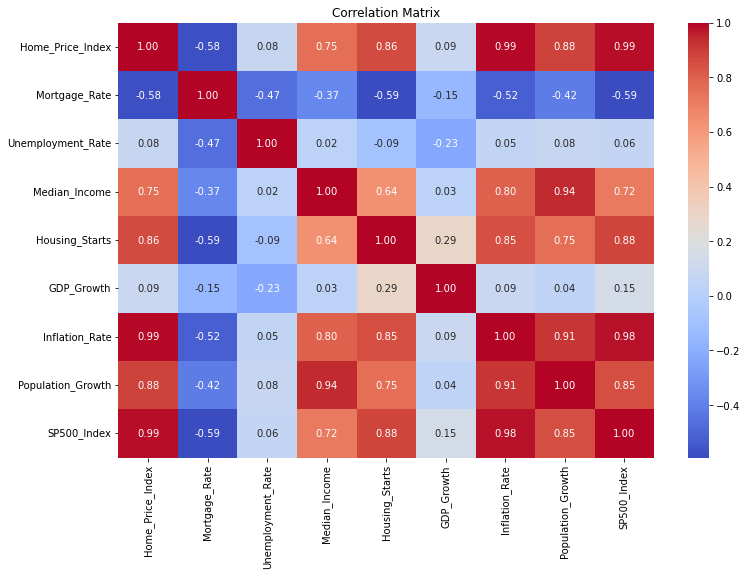

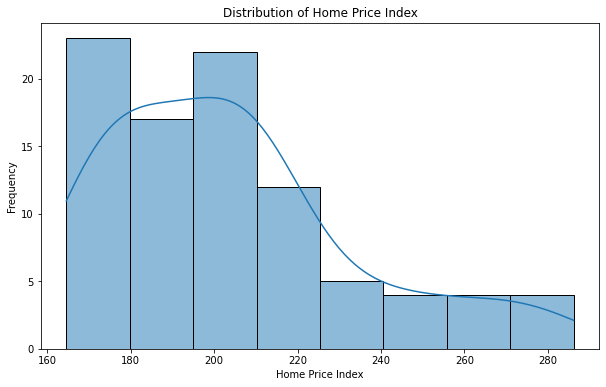

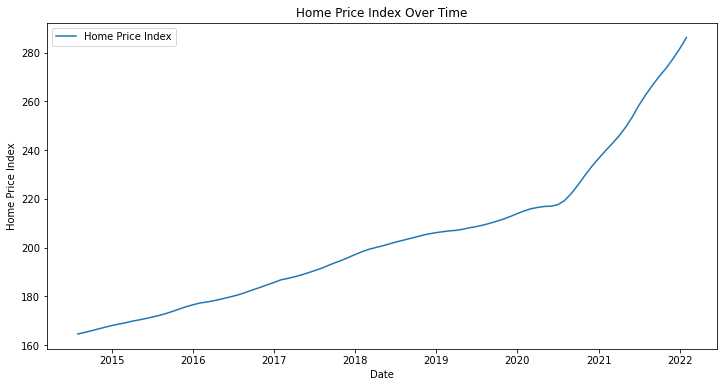

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Summary statistics
print("\nSummary statistics:")
print(data.describe())

# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Distribution of Home Price Index
plt.figure(figsize=(10, 6))
sns.histplot(data['Home_Price_Index'], kde=True)
plt.title('Distribution of Home Price Index')
plt.xlabel('Home Price Index')
plt.ylabel('Frequency')
plt.show()

# Time series plot of Home Price Index
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Home_Price_Index'], label='Home Price Index')
plt.xlabel('Date')
plt.ylabel('Home Price Index')
plt.title('Home Price Index Over Time')
plt.legend()
plt.show()


## Feature Engineering

In [4]:
# Feature engineering: Creating lag features
data['Lag_1'] = data['Home_Price_Index'].shift(1)
data['Lag_2'] = data['Home_Price_Index'].shift(2)

# Drop rows with NaN values created by lag features
data.dropna(inplace=True)

# Re-define features and target
X = data.drop('Home_Price_Index', axis=1)
y = data['Home_Price_Index']


## Feature Selection

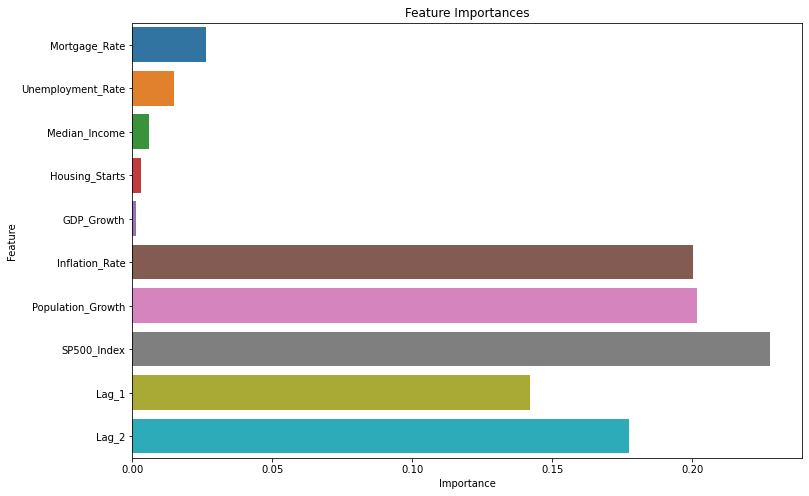

In [5]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importance using RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Plot feature importances
feature_importances = model.feature_importances_
features = X.columns
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances, y=features)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Select features based on importance (e.g., top 5 features)
top_features = [features[i] for i in feature_importances.argsort()[-5:]]
X = X[top_features]


## Model Training and Evaluation

Linear Regression Mean Squared Error: 0.0667789273605956


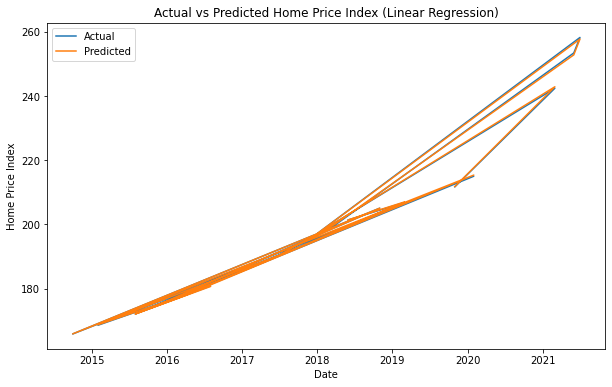

Decision Tree Mean Squared Error: 3.809167555555553


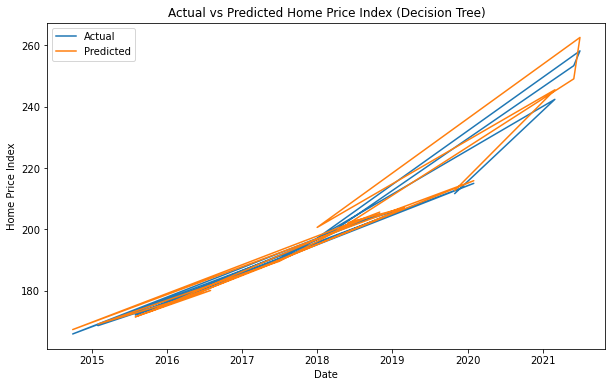

Random Forest Mean Squared Error: 1.524503904605586


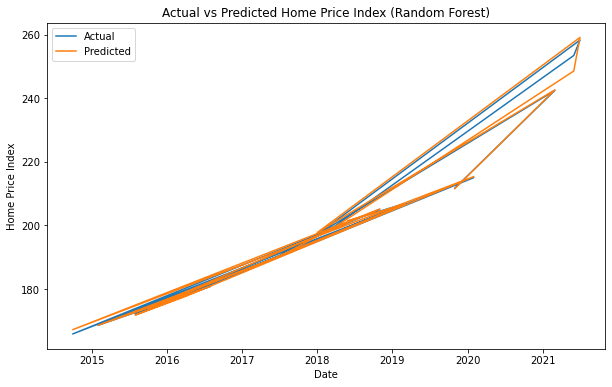

Gradient Boosting Mean Squared Error: 2.1289961624069567


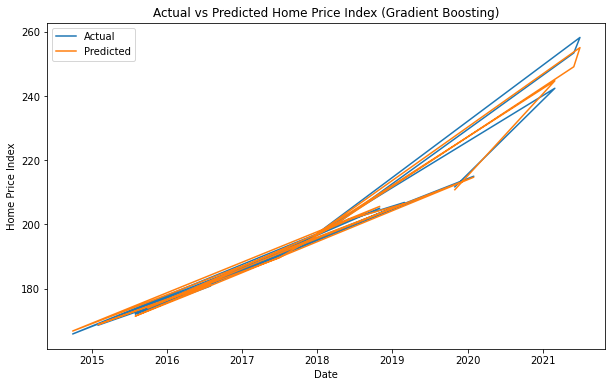

Support Vector Regression Mean Squared Error: 736.4917650853579


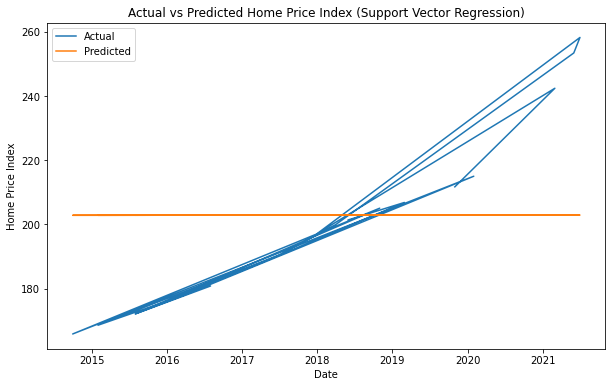

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# List of models to evaluate
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Support Vector Regression": SVR()
}

# Evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name} Mean Squared Error: {mse}")

    # Plot the results for each model
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test, label='Actual')
    plt.plot(y_test.index, y_pred, label='Predicted')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Home Price Index')
    plt.title(f'Actual vs Predicted Home Price Index ({name})')
    plt.show()


## Hyperparameter Tuning

Cross-Validation Scores (Negative MSE): [-0.0355701  -0.05941187 -0.03225251 -0.17218757 -0.53200744]
Mean Cross-Validation Score (Negative MSE): -0.16628589629085452
Standard Deviation of Cross-Validation Scores: 0.18987401090374803
Mean Squared Error on Test Set: 0.0667789273605956


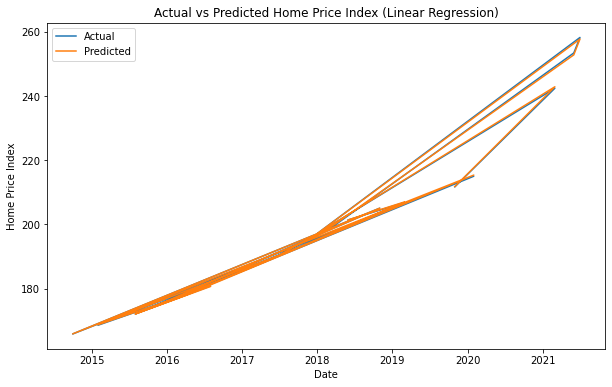

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Initialize Linear Regression model
model = LinearRegression()

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

# Output cross-validation results
print(f"Cross-Validation Scores (Negative MSE): {cv_scores}")
print(f"Mean Cross-Validation Score (Negative MSE): {cv_scores.mean()}")
print(f"Standard Deviation of Cross-Validation Scores: {cv_scores.std()}")

# Fit and evaluate the model on the training and test sets
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on Test Set: {mse}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Home Price Index')
plt.title('Actual vs Predicted Home Price Index (Linear Regression)')
plt.show()
